# Practical Part: Neural Network Implementation & Experiments

Team:
* Jonathan Bhimani-Burrows ()
* Arlie Coles (20121051)
* Yue (Violet) Guo (20120727)

Load the Fashion MNIST data:
Note: keep your file structures like this for reading input data without
using ```import os``` for path change!
```
./Homework 3
├── 3_practical_part.ipynb
├── circles.txt
├── data
│   ├── fashion
│   │   ├── t10k-images-idx3-ubyte.gz
│   │   ├── t10k-labels-idx1-ubyte.gz
│   │   ├── train-images-idx3-ubyte.gz
│   │   └── train-labels-idx1-ubyte.gz
│   └── mnist
│       └── README.md
├── hw3
│   └── d3english.pdf
├── overleaf_url.txt
└── utils
    ├── __init__.py
    ├── __pycache__
    │   ├── __init__.cpython-36.pyc
    │   └── mnist_reader.cpython-36.pyc
    ├── argparser.py
    ├── helper.py
    └── mnist_reader.py
```

In [155]:
import utils.mnist_reader as mnist_reader
import numpy as np
import math
import copy 
import matplotlib.pyplot as plt


In [156]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

print(X_test.shape)

(10000, 784)


Load the Circles data:

In [157]:
a = np.array([1, 2, 3])
b = np.array([2, 3, 4])
print(a.shape)
c= np.stack((a, b))
print(c.T)
print(c.shape)

print(c[0][0])
print(c[1][0])
print(c[0,:])

(3,)
[[1 2]
 [2 3]
 [3 4]]
(2, 3)
1
2
[1 2 3]


In [158]:
circlesData = np.loadtxt(open('circles.txt','r'))
circlesTarget = circlesData[:,2]
circlesData = circlesData[:,[0,1]] 
#circlesData = circlesData
#circlesData = np.expand_dims(circlesData, axis = 1)
#circlesData = circlesData.reshape(1100, 2, 1)
print(circlesData.shape)
circlesTarget = np.array([int(i) for i in circlesTarget])
print(circlesTarget)

(1100, 2)
[1 1 0 ... 0 1 1]


In [159]:
class loadData:
    def __init__(self):
        self.addOnes = False
        self.data_path = '/data/'
    
    def convertTarget(self, targetValues):
        # Convert to one-hot encoding
        numClasses = np.max(targetValues) + 1
        return np.eye(numClasses)[targetValues]
    

    def loadNumData(self, data, target):
        # Split into train/validation/test
        np.random.seed(6390)
        randIndices = np.random.permutation(data.shape[0])
        data, target = data[randIndices], target[randIndices]
        
        div1 = int(math.floor(0.8 * data.shape[0]))
        div2 = int(math.floor(0.9 * data.shape[0]))
        trainData, trainTarget = data[:div1], target[:div1]
        validData, validTarget = data[div1:div2], target[div1:div2]
        testData, testTarget = data[div2:], target[div2:]
    
        # Get one hot encoding
        trainTarget = self.convertTarget(trainTarget)
        validTarget = self.convertTarget(validTarget)
        testTarget = self.convertTarget(testTarget)
        
        return trainData, trainTarget, validData, validTarget, testData, testTarget

dataLoader = loadData()
 
trainData, trainTarget, validData, validTarget, testData, testTarget = dataLoader.loadNumData(circlesData, circlesTarget)
print(trainData.shape, validData.shape, testData.shape)

print(trainTarget.shape)

(880, 2) (110, 2) (110, 2)
(880, 2)


## Experiments

### Part 1

> As a beginning, start with an implementation that computes the gradients for a single example, and check that the gradient is correct using the finite difference method described above.

In [160]:
class BatchSampler(object):
    '''
    randomly sample batches without replacement.
    '''
    
    def __init__(self, data, targets, batch_size):
        self.num_points = data.shape[0]
        self.features = data.shape[1]
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.indices = np.arange(self.num_points)

    def get_batch(self):
        '''
        Get a random batch without replacement 
        '''
        indices = np.random.choice(self.indices, self.batch_size, replace=False)
        X_batch = np.take(self.data, indices, 0)
        y_batch = self.targets[indices]
        return X_batch, y_batch

In [161]:
# Our own activation functions

def relu(pre_activation):
    '''
    preactivation is a vector
    '''
    relu_output = np.zeros(pre_activation.shape)
    relu_flat = relu_output.flatten()
    for i, neuron in enumerate(pre_activation.flatten()):
        if neuron > 0:
            relu_flat[i] = neuron
    relu_output = relu_flat.reshape(pre_activation.shape)
    return relu_output

def softmax(pre_activation):
    '''
    Numerically stable because subtracting the max value makes bit overflow impossible,
    we will only have non-positive values in the vector
    '''
    exps = np.exp(pre_activation - np.max(pre_activation))
    return exps / np.sum(exps)

In [162]:
w1_fixed = np.array([[ 0.20960823 , 0.13663559], [ 0.38623373, -0.32807251] ,[-0.63849439 , 0.0131154 ],
                     [ 0.5142807 ,  0.0595152 ], [-0.31075243 , 0.52335846]])
w2_fixed = np.array( [[ 0.06159592, -0.10424877,  0.23591191 , 0.06177611 , 0.42799154],
                      [ 0.40780062,  0.0759027  , 0.09284926, -0.14837115 ,  0.16844463]])

In [167]:
class neuralNet():
    def __init__(self, d, dh, m, n, eta=3e-4, regularize=None):
        self.inputDim = d #inputDim
        self.hiddenDim = dh #hiddenDim
        self.outputDim = m #outputDim
        self.regularize = regularize # lambda value
        self.learningRate = eta
        self.numData = n
        self.batchErrorGradients = []
        
        #may use xavier init - maybe explore this later.
        
        # Initial weights and biases
        self.W_1 = np.random.uniform(-1/np.sqrt(d), 1/np.sqrt(d), d*dh).reshape(dh, d)
        #w1_fixed
        
        self.W_2 = np.random.uniform(-1/np.sqrt(dh), 1/np.sqrt(dh), dh*m).reshape(m, dh) 
        #w2_fixed
        

        self.b_1 = np.zeros(dh).reshape(dh,)
        self.b_2 = np.zeros(m).reshape(m,)


    def fprop(self, batchData, mode='matrix'):
        if mode == 'matrix':
            stack_b1 = np.array([self.b_1,] * self.numData).T
            self.h_a = np.dot(self.W_1, batchData.T) + stack_b1
        elif mode == 'loop':
            self.h_a = np.dot(self.W_1, batchData.T) + self.b_1
            

        self.h_s = relu(self.h_a)
        
        if mode == 'matrix':
            stack_b2 = np.array([self.b_2,] * self.numData).T
            self.o_a = np.dot(self.W_2, self.h_s) + stack_b2
        elif mode == 'loop':
            self.o_a = np.dot(self.W_2, self.h_s) + self.b_2
            
        self.o_s = softmax(self.o_a)
        if mode == 'loop':
            self.prediction = (np.argmax(self.o_s,axis = 0))
        elif mode == 'matrix':
            self.prediction = (np.argmax(self.o_s,axis = 1))
        
    def errorRate(self, y, mode='matrix'):
        '''
        negative log
        -logO_s(x)
        '''        
        
        if mode == 'loop':
            negLog = -self.o_a[np.argmax(y)] + np.log(np.sum(np.exp(self.o_a), axis=0))
            
        elif mode == 'matrix':
            negLog = []
            for i in range(self.numData):
                error_at_point = -self.o_a[np.argmax(y[:,i])][i] + np.log(np.sum(np.exp(self.o_a), axis=0))[i]
                negLog.append(error_at_point)
            negLog = np.array(negLog)
            negLog = np.mean(negLog)

        return negLog
          
    def bpropLoop(self, batchData, batchTarget):
        self.grad_oa = self.o_s - batchTarget
        self.grad_W2 = np.outer(self.grad_oa, self.h_s.T)
        self.grad_b2 = self.grad_oa
        self.grad_hs = np.dot(self.W_2.T , self.grad_oa)
        h_a_stack = np.where(self.h_a > 0, 1, 0)
        self.grad_ha = np.multiply(self.grad_hs, h_a_stack)
        self.grad_W1 = np.outer(self.grad_ha, batchData)
        self.grad_b1 = self.grad_ha
        
    def bprop(self, batchData, batchTarget, mode='matrix'):
        '''
        batchTarget already in one-hot format
        '''
        
        #batch target must be m by n
        self.grad_oa = self.o_s - batchTarget
        i = 0
        self.grad_W2 = [np.outer(self.grad_oa[:,i], self.h_s[:,i].T) for i in range(self.numData)]
        self.grad_b2 = self.grad_oa #np.mean(self.grad_oa, axis = 1)
        self.grad_hs = np.dot(self.W_2.T , self.grad_oa)
        # Check this (dim mismatch maybe)
        h_a_stack = np.where(self.h_a > 0, 1, 0)
        self.grad_ha = np.multiply(self.grad_hs, h_a_stack)
        self.grad_W1 = [np.outer(self.grad_ha[:,i], batchData[i]) for i in range(self.numData)]
        # temporary hack for grad_W
        self.grad_b1 = self.grad_ha

    
    def updateParams(self):
        self.W_1 -= self.grad_W1 * self.learningRate
        self.W_2 -= self.grad_W2 * self.learningRate
        self.b_1 -= self.grad_b1 * self.learningRate
        self.b_2 -= self.grad_b2 * self.learningRate
    
    
    def gradDescentLoop(self, batchData, batchTarget, K):
        # Call each example in the data (over the minibatches) in a loop
        grad_W2, grad_b2, grad_W1, grad_b1 = [], [], [], []
        predBatch = []
        for i in range(K):
            self.fprop(batchData[i], mode='loop') #batchTarget[:,i]
            self.bpropLoop(batchData[i],batchTarget[:,i])
            predBatch.append(self.prediction)
            grad_W2.append(self.grad_W2)
            grad_b2.append(self.grad_b2)
            grad_W1.append(self.grad_W1)
            grad_b1.append(self.grad_b1)
        self.grad_W2 = np.mean(grad_W2, axis=0)
        self.grad_b2 = np.mean(grad_b2, axis=0)
        self.grad_W1 = np.mean(grad_W1, axis=0)
        self.grad_b1 = np.mean(grad_b1, axis=0)
        
        # Update params
        #self.updateParams()
    
    def fpropLoop(self, batchData, K):
        '''
        unlike the above def gradDescentLoop(self, batchData, batchTarget, K)
        this function only runs batchData (this is usually in test phase)
        through the forward prop, without calculating any gradient update rule.
        
        Use to get predictions
        
        batchData: more like test/val data
        K: ALWAYS == batchData.shape[0]
        
        '''
        predBatch = []
        for i in range(K):
            self.fprop(batchData[i], mode='loop') #batchTarget[:,i]
            predBatch.append(self.prediction)
        self.predBatch = np.array(predBatch)    
        
    def gradDescentMat(self, batchData, batchTarget):
        # Feed the entire data matrix in as input
        self.fprop(batchData)
        self.bprop(batchData, batchTarget)

        
    def dataSplit(self):
        '''
        train
        test
        valid
        '''
            
'''      
def earlyStopping(net):
    totalEpoch = 10 #may not be enough??
    for each epoch
        train
        valid
        test
        plot / print errors
'''




'      \ndef earlyStopping(net):\n    totalEpoch = 10 #may not be enough??\n    for each epoch\n        train\n        valid\n        test\n        plot / print errors\n'

### Part 2

> Display  the  gradients  for  both  methods (direct computation and finite difference) for a small network (e.g. $d = 2$ and $d_{h} = 2$) with random weights and for a single example.

### Part 3

> Add a hyperparameter for the minibatch size $K$ to allow computing the gradients on a minibatch of $K$ examples (in a matrix), by looping over the $K$ examples (this is a small addition to your previous code).

### Part 4

> Display the gradients for both methods (direct computation and finite difference) for a small network (e.g. $d = 2$ and $d_{h} = 2$) with random weights and for a minibatch with 10 examples (you can use examples from both classes from the two circles dataset).

### Part 5

> Train your neural network using gradient descent on the two circles dataset. Plot the decision regions for several different values of the hyperparameters (weight decay, number of hidden units, early stopping) so as to illustrate their effect on the capacity of the model.

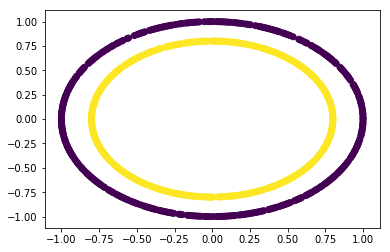

In [168]:
# plot the circle training dataset

plotTrainTarget = np.argmax(trainTarget, axis = 1)

plt.scatter(trainData[:,0], trainData[:,1], c=plotTrainTarget)

In [194]:
def train_loop(nn, data, target, K, num_epoch): 

    # Get minibatch
    batchSampler = BatchSampler(data, target, K)
    numBatch = data.shape[0] // K 
    print("numbatch" , numBatch)
    
    for n in range(num_epoch):
        # Do descent and update params - this is one epoch
        for i in range(numBatch):
            batchData, batchTarget = batchSampler.get_batch()
            #print(batchData, batchTarget)
            nn.gradDescentLoop(batchData, batchTarget.T, K)
            nn.updateParams()
    
def plot_decision_boundary(nn, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h betweethem
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    
    newData =np.c_[xx.ravel(), yy.ravel()]
    
    nn.fpropLoop(newData, newData.shape[0])
    Z = nn.predBatch
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def plotDecision(nn, data):
    nn.fpropLoop(data, data.shape[0])
    plt.scatter(data[:,0], data[:,1], c = nn.predBatch)
    plt.show()

numbatch 88
numbatch 88
numbatch 88
numbatch 88
numbatch 88
numbatch 88
numbatch 88


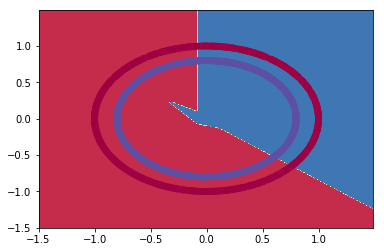

In [201]:
# def train_loop(nn, data, target, K, num_epoch): 
# nn init
# def __init__(self, d, dh, m, n, eta=3e-4, regularize=None):

# Train on circles
# K is Size of batches!!!
K = 10

num_hidden = [2,5,10]
for hidden in num_hidden:
    circleNet = neuralNet(2, hidden, 2, trainData.shape[0] ) # K = 2
    train_loop(circleNet, trainData, trainTarget, K, 1)
    #plotDecision(circleNet,testData)


    
num_epoch = [1,5,10,15]    
for n in num_epoch:
    circleNet = neuralNet(2, 5, 2, trainData.shape[0] ) # K = 2
    train_loop(circleNet, trainData, trainTarget, K, n)
    plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))
    #plotDecision(circleNet,testData)



### Part 6

> As a second step, copy your existing implementation to modify it to a new implementation that will use matrix calculus (instead of a loop) on batches of size $K$ to improve efficiency. **Take the matrix expressions in numpy derived in the first part, and adapt them for a minibatch of size $K$. Show in your report what you have modified (describe the former and new expressions with the shapes of each matrix).**

### Part 7

> Compare both implementations (with a loop and with matrix calculus) to check that they both give the same values for the gradients on the parameters, first for $K = 1$, then for $K = 10$. Display the gradients for both methods.

### Part 8

> Time how long an epoch takes on Fashion MNIST (1 epoch = 1 full traversal through the whole training set) for $K = 100$ for both versions (loop over a minibatch and matrix caluclus).

### Part 9

> Adapt your code to compute the error (proportion of misclassified examples) on the training set as well as the total loss on the training set during each epoch of the training procedure, and at the end of each epoch, it computes the error and average loss on the validation set and the test set. Display the 6 corresponding figures (error and average loss on train/valid/test), and write them in a log file.

### Part 10

> Train your network on the Fashion MNIST dataset. Plot the training/valid/test curves (error and loss as a function of the epoch number, corresponding to what you wrote in a file in the last question). Add to your report the curves obtained using your best hyperparameters, i.e. for which you obtained your best error on the validations et. We suggest 2 plots: the first one will plot the error rate (train/valid/test with different colors, show which color in a legend) and the other one for the averaged loss (on train/valid/test). You should be able to get less than 20% test error.